(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

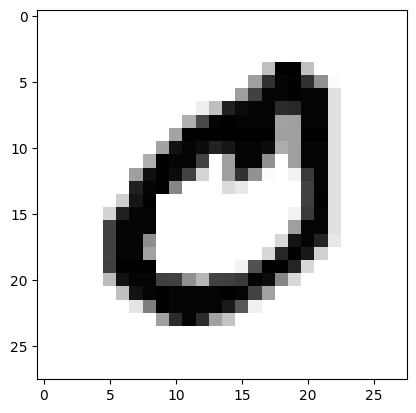

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(12046)
dataset=datasets.MNIST(root='./mnist',train=True,download=True,transform=transforms.ToTensor())
print(dataset[21])
x,y=dataset[21]
print(x.shape)
plt.imshow(x.squeeze(0).numpy(),cmap=plt.cm.binary)


In [16]:
train_set,val_set=random_split(dataset,[50000,10000])
test_set=datasets.MNIST(root='./mnist',train=False,download=True,transform=transforms.ToTensor())
train_loader=DataLoader(train_set,batch_size=500,shuffle=True)
val_loader=DataLoader(val_set,batch_size=500,shuffle=True)
test_loader=DataLoader(test_set,batch_size=500,shuffle=True)
x,y=next(iter(train_loader))
print(x.shape,y.shape)
x.view(x.shape[0],-1).shape

torch.Size([500, 1, 28, 28]) torch.Size([500])


torch.Size([500, 784])

In [17]:
#生成模型
model=nn.Sequential(
    nn.Linear(28*28,30),nn.Sigmoid(),
    nn.Linear(30,20),nn.Sigmoid(),
    nn.Linear(20,10)
)
#评估模型
eval_iters=10#超参数

def estimate_loss(model):
    re={}
    re['train']=_loss(model,train_loader)
    re['val']=_loss(model,val_loader)
    re['test']=_loss(model,test_loader)
    return re

@torch.no_grad()
def _loss(model,dataloader):
    loss=[]
    acc=[]
    data_iter=iter(dataloader)
    for t in range(eval_iters):
        inputs,labels=next(data_iter)
        #inputs:(500,1,28,28)
        #labels:(500)
        B,C,H,W=inputs.shape
        logits=model(inputs.view(B,-1))
        loss.append(F.cross_entropy(logits,labels))
        preds=torch.argmax(logits,dim=-1)
        acc.append((preds==labels).sum()/B)
    re={
        'loss':torch.tensor(loss).mean().item(),
        'acc':torch.tensor(acc).mean().item()
    }
    return re
estimate_loss(model)

{'train': {'loss': 2.3540306091308594, 'acc': 0.1021999940276146},
 'val': {'loss': 2.36007022857666, 'acc': 0.10199999809265137},
 'test': {'loss': 2.3542590141296387, 'acc': 0.10559999942779541}}

In [19]:
def train_model(model,optimizer,epochs=10):
    lossi=[]
    for e in range(epochs):
        for data in train_loader:
            inputs,labels=data
            B,C,H,W=inputs.shape
            logits=model(inputs.view(B,-1))
            loss=F.cross_entropy(logits,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        stats=estimate_loss(model)
        train_loss=f'{stats["train"]["loss"]:.4f}'
        val_loss=f'{stats["val"]["loss"]:.4f}'
        test_loss=f'{stats["test"]["loss"]:.4f}'
        print(f'Epoch {e} train{train_loss},val{val_loss},test{test_loss}')
    return lossi
loss={}

In [20]:
model=nn.Sequential(
    nn.Linear(28*28,30),nn.Sigmoid(),
    nn.Linear(30,20),nn.Sigmoid(),
    nn.Linear(20,10)
)
loss['mlp']=train_model(model,optim.SGD(model.parameters(),lr=0.01))

Epoch 0 train2.3105,val2.3096,test2.3101
Epoch 1 train2.3020,val2.3035,test2.3022
Epoch 2 train2.2990,val2.3007,test2.3002
Epoch 3 train2.2986,val2.3003,test2.2998
Epoch 4 train2.2998,val2.2990,test2.2984
Epoch 5 train2.2978,val2.2994,test2.2982
Epoch 6 train2.2974,val2.2997,test2.2976
Epoch 7 train2.2960,val2.2989,test2.2980
Epoch 8 train2.2954,val2.2974,test2.2957
Epoch 9 train2.2957,val2.2976,test2.2961


In [22]:
model=nn.Sequential(
    nn.Linear(28*28,30),nn.ReLU(),
    nn.Linear(30,20),nn.ReLU(),
    nn.Linear(20,10)
)
loss['mlp_relu']=train_model(model,optim.SGD(model.parameters(),lr=0.01))

Epoch 0 train2.2976,val2.2961,test2.2924
Epoch 1 train2.2688,val2.2715,test2.2691
Epoch 2 train2.2198,val2.2238,test2.2169
Epoch 3 train2.1447,val2.1453,test2.1385
Epoch 4 train2.0157,val2.0130,test1.9986
Epoch 5 train1.8157,val1.8202,test1.8020
Epoch 6 train1.6075,val1.5986,test1.5918
Epoch 7 train1.4156,val1.4017,test1.3997
Epoch 8 train1.2511,val1.2513,test1.2380
Epoch 9 train1.1250,val1.1414,test1.1108


In [23]:
model=nn.Sequential(
    nn.Linear(28*28,30,bias=False),nn.LayerNorm(30),nn.ReLU(),
    nn.Linear(30,20,bias=False),nn.LayerNorm(20),nn.ReLU(),
    nn.Linear(20,10)
)
loss['mlp_relu_layer']=train_model(model,optim.SGD(model.parameters(),lr=0.01))

Epoch 0 train1.5017,val1.5163,test1.5006
Epoch 1 train1.0977,val1.1131,test1.0975
Epoch 2 train0.8201,val0.8227,test0.8152
Epoch 3 train0.6339,val0.6295,test0.6299
Epoch 4 train0.4916,val0.5153,test0.4929
Epoch 5 train0.4099,val0.4212,test0.4073
Epoch 6 train0.3575,val0.3739,test0.3583
Epoch 7 train0.3210,val0.3292,test0.3363
Epoch 8 train0.2975,val0.3146,test0.3170
Epoch 9 train0.2709,val0.2884,test0.2684


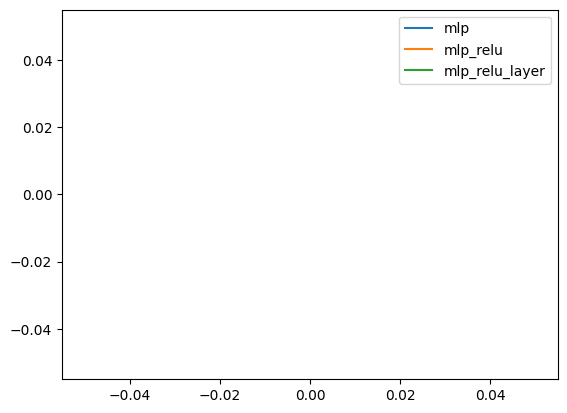

In [30]:
for i in ['mlp','mlp_relu','mlp_relu_layer']:
    plt.plot(torch.tensor(loss[i]),label=i)
plt.legend()
plt.show()